In [2]:
import os
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tqdm import tqdm
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import clipboard
import base64
from io import BytesIO
from PIL import Image
from proxyattention.meta_utils import read_pickle


In [ ]:
!ls test

In [5]:
!python result_aggregator.py

  0%|                                                    | 0/35 [00:00<?, ?it/s]2023-03-17 18:02:56.027811: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 18:02:57.573443: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/eragon/miniconda3/envs/pytorcher/lib/python3.10/site-packages/cv2/../../lib64:/home/eragon/miniconda3/envs/pytorcher/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-17 18:02:57.578331: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plug

In [6]:
combined_df = read_pickle(fname = "./results/aggregated_runs.csv")[0]
combined_df = combined_df[(~pd.isnull(combined_df['experiment_name'])) & (~pd.isnull(combined_df['Loss/Val']))]
combined_df.head()

,index,proxy_step,Loss/Train,Acc/Train,Loss/Val,Acc/Val,experiment_name,image_size,batch_size,enable_proxy_attention,...,name_fn,global_run_count,label_map,rev_label_map,num_classes,original_images,converted_proxy,Number_Chosen,save_path,final_acc
0,runs/baseline_run_17032023_17:45:34/events.out...,0.0,2.360496,0.102,2.308809,0.116,baseline_run,224,16,True,...,<function get_parent_name at 0x7f69eff68040>,0,"{0: 'n01440764', 1: 'n02102040', 2: 'n02979186...","{'n01440764': 0, 'n02102040': 1, 'n02979186': ...",10,NaN,NaN,NaN,NaN,NaN
1,runs/baseline_run_17032023_17:45:34/events.out...,1.0,2.319051,0.088,2.302496,0.1,baseline_run,224,16,True,...,<function get_parent_name at 0x7f69eff68040>,2,"{0: 'n01440764', 1: 'n02102040', 2: 'n02979186...","{'n01440764': 0, 'n02102040': 1, 'n02979186': ...",10,<PIL.PngImagePlugin.PngImageFile image mode=RG...,<PIL.PngImagePlugin.PngImageFile image mode=RG...,13.0,/mnt/e/CODE/Github/improving_robotics_datasets...,"tensor(0.1160, device='cuda:0', dtype=torch.fl..."
2,runs/baseline_run_17032023_17:47:08/events.out...,0.0,2.759705,0.306,2.079623,0.474,baseline_run,224,16,True,...,<function get_parent_name at 0x7f69eff68040>,0,"{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F...","{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': ...",29,NaN,NaN,NaN,/mnt/e/CODE/Github/improving_robotics_datasets...,"tensor(0.1000, device='cuda:0', dtype=torch.fl..."
3,runs/baseline_run_17032023_17:47:08/events.out...,1.0,2.144491,0.408,1.2186,0.634,baseline_run,224,16,True,...,<function get_parent_name at 0x7f69eff68040>,2,"{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F...","{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': ...",29,<PIL.PngImagePlugin.PngImageFile image mode=RG...,<PIL.PngImagePlugin.PngImageFile image mode=RG...,8.0,/mnt/e/CODE/Github/improving_robotics_datasets...,"tensor(0.4740, device='cuda:0', dtype=torch.fl..."
4,runs/baseline_run_17032023_17:47:48/events.out...,0.0,2.326023,0.134,2.296881,0.116,baseline_run,224,16,True,...,<function get_parent_name at 0x7f69eff68040>,0,"{0: 'n01440764', 1: 'n02102040', 2: 'n02979186...","{'n01440764': 0, 'n02102040': 1, 'n02979186': ...",10,NaN,NaN,NaN,/mnt/e/CODE/Github/improving_robotics_datasets...,"tensor(0.6340, device='cuda:0', dtype=torch.fl..."


In [7]:
combined_df.shape

(28, 37)

In [8]:
combined_df[combined_df["global_run_count"]!= "0"]["proxy_steps"].value_counts()

[2, 'p']    14
Name: proxy_steps, dtype: int64

# Image code

In [9]:
filtered_df = combined_df[(~pd.isnull(combined_df['converted_proxy'])) & (~pd.isnull(combined_df['original_images']))]

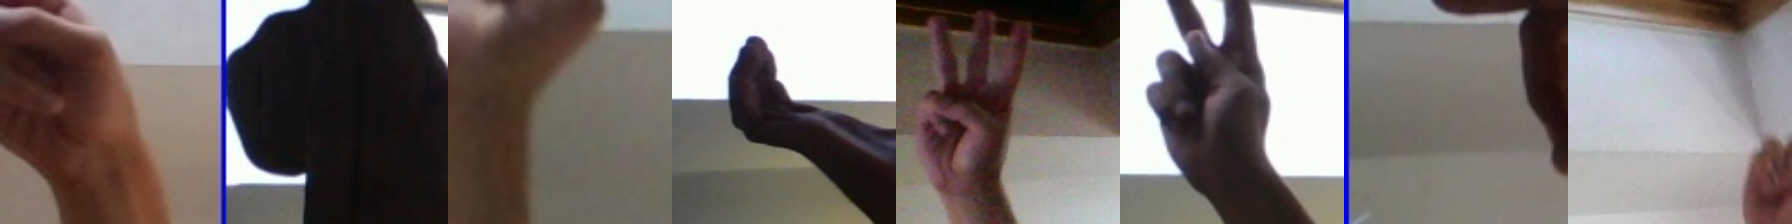

In [10]:
filtered_df.iloc[1].original_images

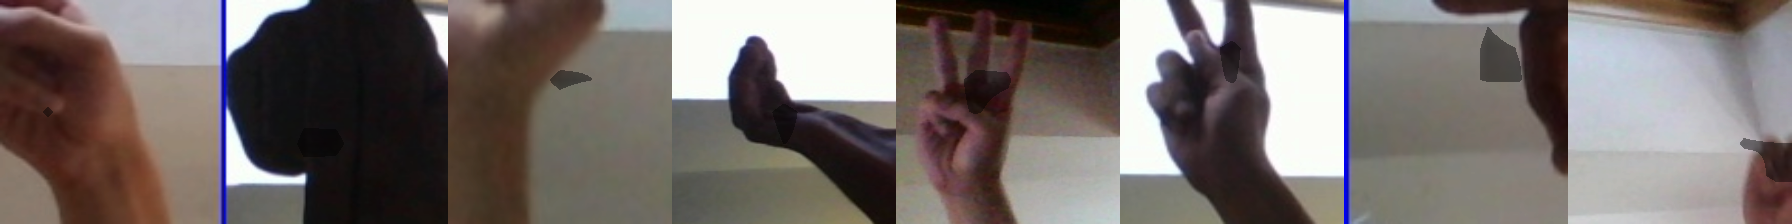

In [11]:
filtered_df.iloc[1].converted_proxy

# Preprocess

In [12]:
def check_proxy(string): return "p" in string

In [13]:
def calc_stats(values):
    return f"min: {values.min()} \nmax: {values.max()} \navg: {values.mean()}"

In [14]:
def convert_float(df, cols, totype= float):
    for col in cols:
        df[col] = df[col].astype(totype)

In [15]:
combined_df = combined_df.fillna(0)
# col to check for proxy
# combined_df["has_proxy"] = combined_df["proxy_steps"].apply(check_proxy)
# Fix naming
combined_df = combined_df.rename(columns={"Acc/Val":"accuracy", "proxy_steps":"step_schedule"})
# Fix types
convert_float(combined_df, ["change_subset_attention", "proxy_threshold", "accuracy"], float)
convert_float(combined_df, ["global_run_count"], int)
convert_float(combined_df, ["transfer_imagenet"], bool)

# ignore failed runs
combined_df = combined_df[combined_df["global_run_count"]!=0]


# Grouped Results

In [16]:
def return_grouped_results(df, group_cols ,filter = None, index_cols = (["ds_name", ("accuracy")]), print_latex = False):
    if filter != None:
        df = df.reset_index()
        for key in filter.keys():
            df = df[df[key] == filter[key]]
    final_df = pd.DataFrame(df.groupby(group_cols, as_index=True).mean(numeric_only = True)["accuracy"]).sort_values(index_cols, ascending=False)
    if print_latex == True:
        clipboard.copy(final_df.to_latex())

    return final_df



In [24]:
return_grouped_results(combined_df, ["ds_name", "pixel_replacement_method", "transfer_imagenet", "gradient_method", "step_schedule"], filter = {"transfer_imagenet":True , "ds_name":"asl"})

,,,,,accuracy
ds_name,pixel_replacement_method,transfer_imagenet,gradient_method,step_schedule,
asl,blended,True,gradcamplusplus,"[10, 'p', 10]",0.966371


In [17]:
return_grouped_results(combined_df, ["ds_name", "pixel_replacement_method", "transfer_imagenet", "gradient_method", "step_schedule", "global_run_count"])

,,,,,,accuracy
ds_name,pixel_replacement_method,transfer_imagenet,gradient_method,step_schedule,global_run_count,
imagenette,blended,True,gradcamplusplus,"[2, 'p']",2,0.403667
asl,blended,True,gradcamplusplus,"[2, 'p']",2,0.328500


In [20]:
return_grouped_results(combined_df, ["ds_name", "pixel_replacement_method", "transfer_imagenet", "gradient_method", "change_subset_attention", "step_schedule", "proxy_image_weight",  "model"])

accuracy
ds_name    pixel_replacement_method transfer_imagenet gradient_method change_subset_attention step_schedule proxy_image_weight model             
imagenette blended                  True              gradcamplusplus 0.5                     [2, 'p']      0.5                resnet50  0.946000
                                                                      0.8                     [2, 'p']      0.8                resnet50  0.936000
                                                                      0.5                     [2, 'p']      0.5                vgg16     0.147000
                                                                      0.2                     [2, 'p']      0.2                vgg16     0.146000
                                                                      0.8                     [2, 'p']      0.8                vgg16     0.100000
asl        blended                  True              gradcamplusplus 0.8                     [2, 'p']      0.8                resnet50  0.714000
                                                                      0.5                     [2, 'p']      0.5                resnet50  0.634000
                                                                      0.2                     [2, 'p']      0.2                resnet50  0.632000
                                                                      0.5                     [2, 'p']      0.5                resnet18  0.484000
                                                                      0.2                     [2, 'p']      0.2                vgg16     0.044667
                                                                      0.8                     [2, 'p']      0.8                vgg16     0.030000

# Compare CAM

In [94]:
test_models = return_grouped_results(combined_df, ["index","ds_name", "pixel_replacement_method", "transfer_imagenet", "gradient_method", "step_schedule", "model", "num_classes"], filter = {"transfer_imagenet":True })

test_models = test_models.reset_index()

In [95]:
model_1, model_2 = test_models.loc[:1].values

In [96]:
model_1

array(["runs/imagenette_threshold_test+09032023_11:37:11_ps-[10, 'p', 10]_gradient-gradcamplusplus_px-blended-subs-0.8_pt-0.5723034991510582_cs-True/events.out.tfevents.1678358581.Eragon.19906.22",
       'imagenette', 'blended', True, 'gradcamplusplus', "[10, 'p', 10]",
       'resnet18', '10', 0.7462499737739563], dtype=object)

In [113]:
import torch
from proxyattention.training import choose_network, perform_proxy_step

import albumentations as A

from albumentations.pytorch import ToTensorV2
from proxyattention.data_utils import ImageClassDs, create_folds, get_parent_name

In [129]:
arch_1 = choose_network({"model":model_1[-3] , "transfer_imagenet":False, "num_classes": int(model_1[-2]), "device":"cpu"})
model_weights = torch.load(Path(model_1[0]).parent/"checkpoint", map_location='cpu')
arch_1.load_state_dict(model_weights['model_state_dict'])
arch_1.eval();

In [126]:
config = {"image_size": 224, "subset_images":100, "load_proxy_data":False, "name_fn":get_parent_name, "ds_path": "/Users/eragon/Documents/CODE/Datasets/imagenette2-320/val", "batch_size":10}

In [118]:
data_transforms = A.Compose(
            [
                A.Resize(config["image_size"], config["image_size"]),
                A.CenterCrop(config["image_size"], config["image_size"], p=1.0),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                    max_pixel_value=255.0,
                    p=1.0,
                ),
                ToTensorV2(p=1.0),
            ],
            p=1.0,
        ),


In [119]:
val = create_folds(config=config)

In [123]:
image_datasets = ImageClassDs(
            val[0], config["ds_path"], train=False, transforms=data_transforms
        ),


In [127]:
val_dls = torch.utils.data.DataLoader(
        image_datasets,
        batch_size=config["batch_size"],
        shuffle=False,
        num_workers=8,
    ),


In [1]:
arch_1(val_dls)

NameError: name 'arch_1' is not defined